In [126]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from collections import deque
from sklearn import preprocessing

## Data Processing

In [127]:
# df = pd.read_csv('DenoisngData.csv', index_col=0)
# df.drop('timestemp', axis = 1, inplace=True)

In [161]:
df = pd.read_csv('/Users/bowen/Desktop/H/deeplearninveststrat/Data/100_clean.csv', index_col=0)
df.drop(['Ticker', 'Date', 'Adjusted Close', 'Volume'], axis = 1, inplace=True)

In [175]:
X_train_total = []
Y_train_total = []

X_test_total = []
Y_test_total = []

seq_len = 12
keys = df['gvkey'].unique()


for key in keys:
    if (key == 8214) or (key==15350):
        print(key)
        continue
    df_temp = df[df['gvkey']==key].drop('gvkey', axis=1) 
    if len(df_temp) != 115:
        print(f'we drop the {key}')
        continue
    y_1 = df_temp['EBIT/EV']
    y_0 = df_temp['EBIT/EV'].shift(1)
    df_temp['return'] = (y_1-y_0)/pd.DataFrame([y_1, y_0]).T.abs().max(axis=1)
#     df_temp['return'] = (y_1-y_0)/np.mean(np.abs(y_1), np.abs(y_0))
#     df_temp['return'] = (df_temp['EBIT/EV']-df_temp['EBIT/EV'].shift(1))/df_temp['EBIT/EV'].shift(1)
    df_temp.drop('EBIT/EV', axis=1, inplace = True) 
    df_temp.dropna(inplace=True)
    col_names = df_temp.columns.values
    min_max_scaler = preprocessing.MinMaxScaler()
    df_temp.loc[:, col_names[:-1]] = min_max_scaler.fit_transform(df_temp.loc[:, col_names[:-1]])
    df_temp.ffill(inplace=True)
    
    X_list = []
    Y_list = []
    for i in range(len(df_temp)-seq_len-1):
        X_list += [df_temp.iloc[i:i+seq_len].values]
        Y_list += [df_temp.iloc[i+seq_len+1, -1]]

    X = np.array(X_list)
    Y = np.array(Y_list)

    # First 72 quarters are for training
    if X.shape[0] >= 5: # Some gvkeys have no insufficient data (dont have 12 quarters of data).
                              # >=5 to ensure there is testing data.
        X_train = X[:int(len(X)*0.7)]
        X_test = X[int(len(X)*0.7):]

        Y_train = Y[:int(len(X)*0.7)]
        Y_test = Y[int(len(X)*0.7):]

        X_train_total += [X_train]
        X_test_total += [X_test]

        Y_train_total += [Y_train]
        Y_test_total += [Y_test]

we drop the 2698
we drop the 5680
we drop the 5709
we drop the 5903
we drop the 6135
we drop the 8092
8214
we drop the 10565
we drop the 11012
we drop the 11017
we drop the 12304
we drop the 12785
we drop the 13400
we drop the 13679
15350
we drop the 17175
we drop the 17422
we drop the 19602
we drop the 21807
we drop the 21824
we drop the 22964
we drop the 23109
we drop the 23337
we drop the 24552
we drop the 25740
we drop the 25750
we drop the 28347
we drop the 30241
we drop the 32796
we drop the 33047
we drop the 33048
we drop the 33068
we drop the 33081
we drop the 33150
we drop the 33279
we drop the 33652
we drop the 105394
we drop the 107154
we drop the 107245
we drop the 107712
we drop the 107781
we drop the 108768
we drop the 108831
we drop the 115044
we drop the 134305
we drop the 143770
we drop the 146659
we drop the 148239
we drop the 149683
we drop the 162453
we drop the 162914
we drop the 163596
we drop the 170920
we drop the 174428
we drop the 185323
we drop the 185689
we 

In [176]:
X_train_total = np.vstack(X_train_total)
X_test_total = np.vstack(X_test_total)

Y_train_total = np.concatenate(Y_train_total)
Y_test_total = np.concatenate(Y_test_total)

In [177]:
for i in [X_train_total, X_test_total,Y_train_total,Y_test_total]:
    print(f'shape is {i.shape}')

shape is (2940, 12, 17)
shape is (1302, 12, 17)
shape is (2940,)
shape is (1302,)


## Model 

In [182]:
tf.reset_default_graph()

hm_epochs = 200
n_classes = 1
n_batches = 4
batch_size = X_train.shape[0] / n_batches
chunk_size = X_train.shape[2]
rnn_size = 64
num_layers = 1

x = tf.placeholder('float', [None, seq_len, chunk_size])
y = tf.placeholder('float')

In [183]:
def recurrent_neural_network(x):
    layer = {'weights': tf.Variable(tf.random_normal([rnn_size, n_classes])),
             'biases': tf.Variable(tf.random_normal([n_classes]))}

#     layer = {'weights':tf.Variable(np.random.normal(size=(rnn_size,n_classes)).astype('float32')),
#              'biases':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(x, seq_len, 0)

    lstm_cells = []
    
    for li in range(num_layers):
        lstm_cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True, initializer=tf.contrib.layers.xavier_initializer())
        dropout_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=1.0, output_keep_prob=1.0)
        lstm_cells.append(dropout_cell)
        
    multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

    outputs, states = rnn.static_rnn(multi_cell, x, dtype=tf.float32)
    output = tf.matmul(outputs[-1], layer['weights']) + layer['biases']  # softmax layer

#     attention_weights = tf.Variable(np.append(np.random.normal(size=seq_len-1), 5))
#     attention_weights = tf.Variable(tf.random_normal([seq_len]))
#     attention_ouput = tf.reduce_sum(tf.multiply(tf.convert_to_tensor(outputs) , tf.Variable(tf.random_normal([seq_len]))[:, tf.newaxis, tf.newaxis]), axis=0)
#     output = tf.matmul(attention_ouput,layer['weights']) + layer['biases'] # softmax layer

    return output

In [184]:
def train_neural_network(x):
    prediction = recurrent_neural_network(x)
    cost = tf.losses.mean_squared_error(predictions=prediction, labels=y)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for i in range(n_batches):
                epoch_x = X_train[i * int(batch_size):(i + 1) * int(batch_size)]
                epoch_y = Y_train[i * int(batch_size):(i + 1) * int(batch_size)]

                _, c = sess.run([optimizer, cost], feed_dict={
                                x: epoch_x, y: epoch_y})
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',
                  hm_epochs, 'loss:', np.mean(epoch_loss))

        pred_train = sess.run(prediction, feed_dict={
                              x: X_train.astype('float32')})[:, 0]
        pred_test = sess.run(prediction, feed_dict={
                             x: X_test.astype('float32')})[:, 0]

        print('Testing MAE:', np.mean(np.abs(pred_test - Y_test)))
        print('Testing MSE:', np.mean((pred_test - Y_test)**2))

        plt.style.use('ggplot')

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
        ax.plot(Y_train, label='True values', color='blue')
        #ax.plot(X_train[:, -1, -1], label='No Model',linestyle='--', color='black')
        ax.plot(pred_train, label='RNN', color='red')
        ax.legend()
        plt.title('Training Predictions')
        plt.show()

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
        ax.plot(Y_test, label='True values', color='blue')
        #ax.plot(X_test[:, -1, -1], label='No Model',linestyle='--', color='black')
        ax.plot(pred_test, label='RNN', color='red')
        ax.legend()
        plt.title('Testing Predictions')
        plt.show()
        
        return 

Epoch 0 completed out of 200 loss: 5.90008932352066
Epoch 1 completed out of 200 loss: 2.386248044669628
Epoch 2 completed out of 200 loss: 2.3048850893974304
Epoch 3 completed out of 200 loss: 1.0217266082763672
Epoch 4 completed out of 200 loss: 1.0823425278067589
Epoch 5 completed out of 200 loss: 1.2505066990852356
Epoch 6 completed out of 200 loss: 0.9992626905441284
Epoch 7 completed out of 200 loss: 0.8455924838781357
Epoch 8 completed out of 200 loss: 0.910894587635994
Epoch 9 completed out of 200 loss: 0.927399292588234
Epoch 10 completed out of 200 loss: 0.872211754322052
Epoch 11 completed out of 200 loss: 0.859071247279644
Epoch 12 completed out of 200 loss: 0.8634054288268089
Epoch 13 completed out of 200 loss: 0.8458416610956192
Epoch 14 completed out of 200 loss: 0.8350624591112137
Epoch 15 completed out of 200 loss: 0.8388177827000618
Epoch 16 completed out of 200 loss: 0.8374738544225693
Epoch 17 completed out of 200 loss: 0.8327373117208481
Epoch 18 completed out of 2

Epoch 154 completed out of 200 loss: 0.7955643758177757
Epoch 155 completed out of 200 loss: 0.7955414205789566
Epoch 156 completed out of 200 loss: 0.7955185547471046
Epoch 157 completed out of 200 loss: 0.7954958453774452
Epoch 158 completed out of 200 loss: 0.7954732999205589
Epoch 159 completed out of 200 loss: 0.7954509034752846
Epoch 160 completed out of 200 loss: 0.7954287678003311
Epoch 161 completed out of 200 loss: 0.7954066470265388
Epoch 162 completed out of 200 loss: 0.7953846901655197
Epoch 163 completed out of 200 loss: 0.7953628450632095
Epoch 164 completed out of 200 loss: 0.795341245830059
Epoch 165 completed out of 200 loss: 0.7953197658061981
Epoch 166 completed out of 200 loss: 0.7952982932329178
Epoch 167 completed out of 200 loss: 0.795277051627636
Epoch 168 completed out of 200 loss: 0.7952559590339661
Epoch 169 completed out of 200 loss: 0.7952349111437798
Epoch 170 completed out of 200 loss: 0.7952140122652054
Epoch 171 completed out of 200 loss: 0.79519326984

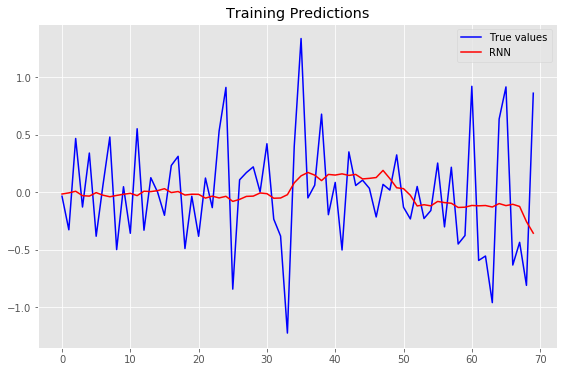

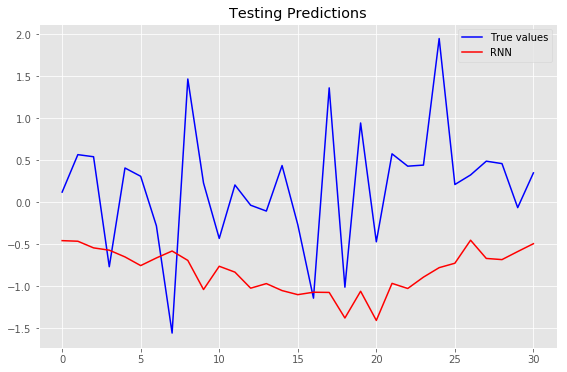

In [185]:
train_neural_network(x)